<a href="https://colab.research.google.com/github/saimani5/VAE-tutorials/blob/main/ssrVAE_cards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*   This notebook takes you through the application of rotationally invariant semi-supervised variational autoencoder (ssrVAE) on two different cards datasets and the results analysis.  
*   Each cards dataset if formed by applying a random rotation and shear to the images of the cards. The datasets differ in the limits used for picking the rotations and shear.

*   semi-supervised autoencoder learns the patterns from the supervised dataset and applies it to the unsupervised dataset.
*   It not only predicts the classes of the supervised dataset, but also encodes them in the latent space condistioned on the predicted class.
*   This combination makes the ss-rVAE an exciting option to predict the class label of the unsupervised which is generated using a different distributions to that of the supervised dataset.
*   So, we form m independent latent spaces for a given dataset, where m is the number of classes present in the dataset.
*   On top of this ssrVAE (from pyroved) can also be used to condition the encodings on a continuous ground truth property associated with each data point. This is not discussed in this notebook.
*   rVAE comprises of an additional latent dimension to the regular VAE, which explicitly captures the rotations involved in the image.
*   This angular latent dimension is unsupervisedly learned while trying to reconstuct the original image.
*   Like in VAE, this latent dimension is also regularized using a prior.  

The ssrVAEs are defined and trained using a package called Pyroved (https://github.com/ziatdinovmax/pyroVED) which is built on top of Pyro probabilistic programming framework. Please feel free to write to valletisai.mani@gmail.com for further enquiries.

In [ ]:
# Installing Kornia and pyroved
!pip install -q kornia git+https://github.com/ziatdinovmax/pyroVED@main

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.0/612.0 KB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 45.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
plotnine 0.10.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have matplotlib 3.3.4 which is incompatible.


In [ ]:
# Importing necessary packages

import pyroved as pv
import kornia as K


import cv2
from torchvision.utils import make_grid
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 3

tt = torch.tensor

In [ ]:
#@title Helper functions that apply afffine transformations to the dataset
rs = lambda x: cv2.resize(x, (64, 64), cv2.INTER_CUBIC)

def get_data():
    !gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
    !unzip -o -qq cards.zip
    card1 = rs(cv2.imread("cards/card1.JPG", cv2.IMREAD_GRAYSCALE))
    card2 = rs(cv2.imread("cards/card2.JPG", cv2.IMREAD_GRAYSCALE))
    card3 = rs(cv2.imread("cards/card3.JPG", cv2.IMREAD_GRAYSCALE))
    card4 = rs(cv2.imread("cards/card4.JPG", cv2.IMREAD_GRAYSCALE))
    card1 = tt(1 - card1 / card1.max())
    card2 = tt(1 - card2 / card2.max())
    card3 = tt(1 - card3 / card3.max())
    card4 = tt(1 - card4 / card4.max())
    return card1, card2, card3, card4


import math
def transform_imgs(cards, **kwargs):
    np.random.seed(0)
    torch.manual_seed(0)

    a = kwargs.get("angle")
    t = kwargs.get("translation")
    s = (kwargs.get("shear"))
    if s is not None:
        s = math.radians(s)
    

    n_samples = kwargs.get("samples", 3000)
    n_samples_total = n_samples*4
    
    card1, card2, card3, card4 = cards[0], cards[1], cards[2], cards[3]

    card1 = card1[None, None].repeat_interleave(n_samples, dim = 0)
    card2 = card2[None, None].repeat_interleave(n_samples, dim = 0)
    card3 = card3[None, None].repeat_interleave(n_samples, dim = 0)
    card4 = card4[None, None].repeat_interleave(n_samples, dim = 0)

    cards_all = torch.cat((card1, card2, card3, card4), dim = 0)

    angles = tt(np.random.uniform(low = -a, high = a, size = [n_samples_total]))
    translations = tt(np.random.uniform(low = -t, high = t, size = [n_samples_total,1])).repeat_interleave(2, dim = 1)
    shears = tt(np.random.uniform(low = -s, high = s, size = [n_samples_total, 1])).repeat_interleave(2, dim = 1)

    transform = nn.Sequential(
        K.augmentation.CenterCrop((48, 48)),
        K.geometry.Affine(angle = angles, translation = translations,
                          shear = shears)
    )

    cards = transform(cards_all).squeeze().float() 
    labels = torch.cat([torch.zeros(len(card1)), torch.ones(len(card2)),
                           2*torch.ones(len(card3)), 3*torch.ones(len(card4))])
    
    labels_onehot = pv.utils.to_onehot(labels.to(torch.int64), 4)
    return cards, labels_onehot, angles, translations, shears


def plot_manifolds(model):   
    fig, axes = plt.subplots(2, 2, figsize=(12, 12),
                            subplot_kw={'xticks':[], 'yticks':[]},
                            gridspec_kw=dict(hspace=0.1, wspace=0.05))
    for i, ax in enumerate(axes.flat):
        manifold = model.manifold2d(d=9, label=i, plot=False)
        grid = make_grid(manifold[:, None], nrow=9, pad_value=.5)
        ax.imshow(grid[0], cmap='viridis')
    plt.show()

In [ ]:
# Downloading the cards dataset
!gdown -q https://drive.google.com/uc?id=1AyGHVflbIjzinkKBURHNVDx1wWg9JixB
!unzip -o -qq cards.zip

# Case-i
In this case, we use the cards dataset (low rotations and low shear) as the supervised dataset i.e., the dataset to which labels are known.  
While the cards dataset with high rotations (120 deg) and low shear is used as the unsupervised dataset


Here we make 2 different datasets using the above helper functions which are as follows:  
*  cardssup1: low rotations (12 degrees) and low shear (1 degree), This will be used as the supervised training dataset
*  cards-train1: high rotations (120 degrees) and low shear (1 degree), This will be used as the unsupervised training dataset (labels)
*   A part of the training dataset is also used as the validation dataset.


In [ ]:
cards = get_data()

# Supervised dataset
cards_sup1, labels_sup1, angles_sup1, translations_sup1, shears_sup1 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 1, samples = 200)

# Unsupervised dataset
# validation set
cards_val1, labels_val1, angles_val1, translations_val1, shears_val1 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 1, samples = 1000)
# Trainin set
cards_train1, labels_train1, angles_train1, translations_train1, shears_train1 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 1, samples = 3000)


In [ ]:
# Creating the dataloaders for the training
# We have three different dataloaders corresponding to unsupervised, supervised, and validation datasets
(loader_unsup1, loader_sup1,
 loader_val1) = pv.utils.init_ssvae_dataloaders(
     cards_train1[:, None], (cards_sup1[:, None], labels_sup1), (cards_val1[:, None], labels_val1), batch_size=50)
 
r = len(loader_sup1) / (len(loader_unsup1) + len(loader_sup1))
print("Ratio of labeled data out of total data: {}".format(r))

Ratio of labeled data out of total data: 0.0625


So, only 6.25% of the input dataset is labeled.  
It should be NOTED that the labeled dataset (low rotations) comes from a different distribution to that of the unlabeled data (high rotations)

In [ ]:
# Training the ss-rVAE, The trained weights will be loaded in the next cell
# So, one can skip this cell to save some time.

data_dim = (48, 48)   # Input dimensions of the dataset i.e., shape of each card's image
latent_dim = 2    # Number of latent dimensions other than the invariancies and class labels
num_classes = 4    # Corresponds to the number of discrete classes in the dataset, these get concatenated to the encoder and decoder automatically

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)

# Initialize model
ssrvae1 = pv.models.ssiVAE(
    data_dim, latent_dim, num_classes, invariances=['r'])

# Initialize trainer
trainer1 = pv.trainers.auxSVItrainer(ssrvae1)


# The KL-scale corresponds to the weight given to the KL-divergence term in the loss function. 
# A higher KL-scale places more emphasis on the KL-divergence term, which encourages the model to learn a more compact latent representation. 


# We're going to ramp-up KL weight from 1 to 2 in the first 30 epochs
kl_scale = torch.linspace(1, 2, 30)
# Train model for n epochs
for e in range(100):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer1.step(loader_unsup1, loader_sup1,
                 aux_loss_multiplier=30, scale_factor=sc)
    trainer1.print_statistics()
    
# Saving the weights of the trained rVAE model on dataset from case-i
ssrvae1.save_weights('/content/drive/MyDrive/VAE Review/ssrvae_files/ssrave_cards1')

Epoch: 1 Training loss: 650.6623
Epoch: 2 Training loss: 366.8936
Epoch: 3 Training loss: 312.9015
Epoch: 4 Training loss: 266.9573
Epoch: 5 Training loss: 243.3666
Epoch: 6 Training loss: 216.7061
Epoch: 7 Training loss: 195.4636
Epoch: 8 Training loss: 182.4156
Epoch: 9 Training loss: 172.2640
Epoch: 10 Training loss: 161.4841
Epoch: 11 Training loss: 151.9438
Epoch: 12 Training loss: 145.9522
Epoch: 13 Training loss: 141.1098
Epoch: 14 Training loss: 138.0164
Epoch: 15 Training loss: 136.5419


In [ ]:
data_dim = (48, 48)
latent_dim = 2
num_classes = 4 

# Initializing a new network
ssrvae1 = pv.models.ssiVAE(
    data_dim, latent_dim, num_classes, invariances=['r'])

# Download the weigths file 
!gdown 11qVyPSJhMhWM3R4doQpjWNv5E_DuhGsw

# Loading the saved weights into the newly initialized network
ssrvae1.load_weights('ssrave_cards1.pt')

Downloading...
From: https://drive.google.com/uc?id=11qVyPSJhMhWM3R4doQpjWNv5E_DuhGsw
To: /content/ssrave_cards1.pt
100% 2.64M/2.64M [00:00<00:00, 238MB/s]


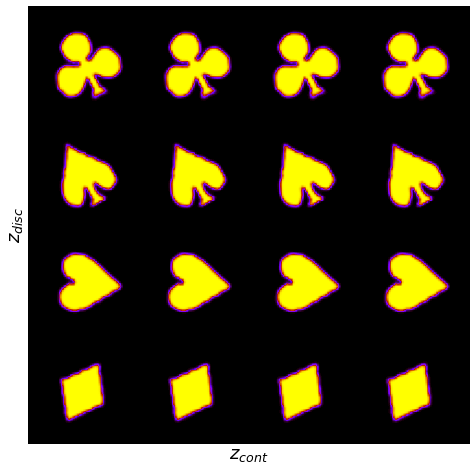

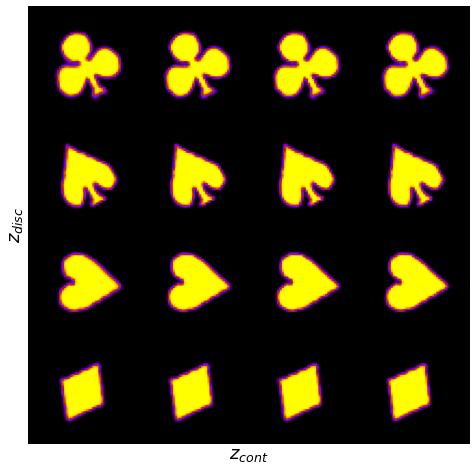

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions. 
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

# Traverse manifold is the decoded latent space in which one of the continouous latent dimension is held at constant (0),
# While the other continuous dimensions and the discrete dimension are used to plot the decoded latent space.

for i in range(2):
    ssrvae1.manifold_traversal(4, i, cmap='gnuplot')

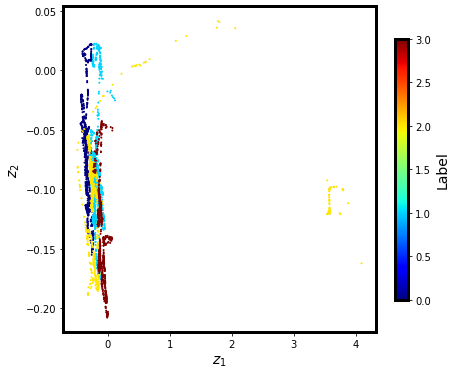

In [ ]:
targets_all1 = torch.argmax(labels_val1, dim = 1)   # Obtaining the classes from one-hot encoded vectors
z_mean1, z_sd1, pred_all1 = ssrvae1.encode(cards_val1.reshape([-1, 48*48]))   # Encoding the full validation dataset

# z_mean1: mean of the latent space representation of the input dataset, 
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions) 
# Pred_all1: predicted class labels for the validation dataset 

# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 1, figsize =(7, 6))
im = ax.scatter(z_mean1[:,-1], z_mean1[:,-2], c=targets_all1, s=1, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
plt.show()

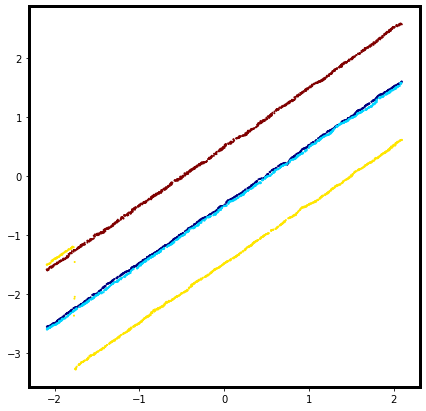

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images. 
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (7,7))
ax.scatter(torch.deg2rad(angles_val1), z_mean1[:,0], c = targets_all1, s =1, cmap = 'jet')

In [ ]:
# As a final step of the analysis, we will visualize the confusion matrix between the predicted and the actual targets

from sklearn.metrics import accuracy_score, confusion_matrix
print('Accuracy on the validation dataset is {}'.format(accuracy_score(y_true = targets_all1, y_pred = pred_all1)))

con_mat = confusion_matrix(y_true = targets_all1, y_pred = pred_all1)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 12)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize =15)
    plt.yticks(tick_marks, classes, rotation=45, fontsize = 15)
    plt.tight_layout()
    plt.ylabel('True label', fontsize = 15)
    plt.xlabel('Predicted label', fontsize = 15)

Accuracy on the validation dataset is 0.984


So, we obtained a 98.4% accuracy on the validation dataset. Although the training and validation dataset come from a different distribution of the data (Higher rotations) than the supervised dataset (Low rotations), the VAE does an extremely good job of learning the patterns from supervised dataset and applying them to the unsupervised dataset.

Normalized confusion matrix
[[1.    0.    0.    0.   ]
 [0.    1.    0.    0.   ]
 [0.064 0.    0.936 0.   ]
 [0.    0.    0.    1.   ]]


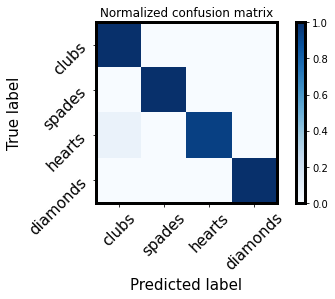

In [ ]:
# The confusion matrix looks like this:

class_names = ['clubs', 'spades', 'hearts', 'diamonds']

#show confusion matrix plot
plt.figure()
plot_confusion_matrix(con_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#Case-ii
In this case, we use the cards dataset (low rotations and low shear) as the supervised dataset i.e., the dataset to which labels are known.  
While the cards dataset with high rotations (120 deg) and low shear is used as the unsupervised dataset

Here we make 2 different datasets using the above helper functions which are as follows:  
*  cardssup1: low rotations (12 degrees) and low shear (1 degree), This will be used as the supervised training dataset
*  cards-train1: high rotations (120 degrees) and high shear (20 degree), This will be used as the unsupervised training dataset (labels)
*   A part of the training dataset is also used as the validation dataset.

In [ ]:
# Supervised dataset
cards_sup2, labels_sup2, angles_sup2, translations_sup2, shears_sup2 = transform_imgs(cards, angle = 12, translation = 0.1, shear = 1, samples = 200)

# Unsupervised dataset
# validation set
cards_val2, labels_val2, angles_val2, translations_val2, shears_val2 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 20, samples = 1000)

# Trainin set
cards_train2, labels_train2, angles_train2, translations_train2, shears_train2 = transform_imgs(cards, angle = 120, translation = 0.1, shear = 20, samples = 3000)

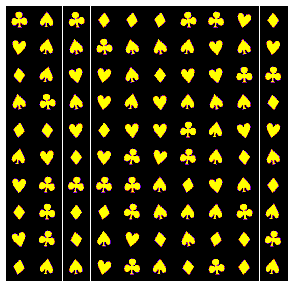

In [ ]:
# First let's just visualize some randomly picked samples from the supervised dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_sup2))
    ax.imshow(cards_sup2[i], cmap='gnuplot', interpolation='nearest')

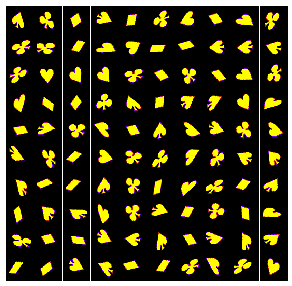

In [ ]:
# First let's just visualize some randomly picked samples from the validation dataset

np.random.seed(1)  # fix seed so that we get the same samples displayed at every run
fig, axes = plt.subplots(10, 10, figsize=(5, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax in axes.flat:
    i = np.random.randint(len(cards_val2))
    ax.imshow(cards_val2[i], cmap='gnuplot', interpolation='nearest')

In [ ]:
# Creating the dataloaders for the training
# We have three different dataloaders corresponding to unsupervised, supervised, and validation datasets
(loader_unsup2, loader_sup2,
 loader_val2) = pv.utils.init_ssvae_dataloaders(
     cards_train2[:, None], (cards_sup2[:, None], labels_sup2), (cards_val2[:, None], labels_val2), batch_size=50)
 
r = len(loader_sup2) / (len(loader_unsup2) + len(loader_sup2))
print("Ratio of labeled data: {}".format(r))

Ratio of labeled data: 0.0625


So, only 6.25% of the input dataset is labeled.  
It should be NOTED that the labeled dataset (low rotations and low shear) comes from a different distribution to that of the unlabeled data (high rotations and high shear)

In [ ]:
# Training the ss-rVAE, The trained weights will be loaded in the next cell
# So, one can skip this cell to save some time.

data_dim = (48, 48)   # Input dimensions of the dataset i.e., shape of each card's image
latent_dim = 2    # Number of latent dimensions other than the invariancies and class labels
num_classes = 4    # Corresponds to the number of discrete classes in the dataset, these get concatenated to the encoder and decoder automatically

# Initialize probabilistic VAE model ->
# (invariances=None: vanilla VAE
#  invariances=['r']: enforces rotational invariance
#  invariances=['t']: enforces translational invariance
#  invariances=['r', 't']: enforces invariance to rotations & translations
#  etc.)


# Initialize model
ssrvae2 = pv.models.ssiVAE(
    data_dim, latent_dim, num_classes, invariances=['r'], 
    hidden_dim_e = [256, 256],   # corresponds to the number of neurons in the hidden layers of the encoder
     hidden_dim_d=[256, 256])   # corresponds to the number of neurons in the hidden layers of the decoder

# Initialize trainer
trainer2 = pv.trainers.auxSVItrainer(ssrvae2)


# The KL-scale corresponds to the weight given to the KL-divergence term in the loss function. 
# A higher KL-scale places more emphasis on the KL-divergence term, which encourages the model to learn a more compact latent representation. 

# We're going to ramp-up KL weight from 1 to 2 in the first 30 epochs
kl_scale = torch.linspace(1, 2, 30)
# Train model for n epochs
for e in range(100):
    sc = kl_scale[e] if e < len(kl_scale) else kl_scale[-1]
    trainer2.step(loader_unsup2, loader_sup2,
                 aux_loss_multiplier=30, scale_factor=sc)
    trainer2.print_statistics()

# Saving the weights of the trained rVAE model on dataset from case-i
ssrvae2.save_weights('/content/drive/MyDrive/VAE Review/ssrvae_files/ssrave_cards2')

Epoch: 1 Training loss: 650.7114
Epoch: 2 Training loss: 419.0767
Epoch: 3 Training loss: 356.5863
Epoch: 4 Training loss: 325.2216
Epoch: 5 Training loss: 301.7186
Epoch: 6 Training loss: 279.2818
Epoch: 7 Training loss: 262.1400
Epoch: 8 Training loss: 251.4584
Epoch: 9 Training loss: 234.3778
Epoch: 10 Training loss: 218.4863
Epoch: 11 Training loss: 203.1768
Epoch: 12 Training loss: 192.6924
Epoch: 13 Training loss: 184.3773
Epoch: 14 Training loss: 177.4159
Epoch: 15 Training loss: 171.6510
Epoch: 16 Training loss: 166.2270
Epoch: 17 Training loss: 162.9481
Epoch: 18 Training loss: 158.8457
Epoch: 19 Training loss: 157.9359
Epoch: 20 Training loss: 152.6546
Epoch: 21 Training loss: 150.0498
Epoch: 22 Training loss: 146.5068
Epoch: 23 Training loss: 149.4850
Epoch: 24 Training loss: 143.4047
Epoch: 25 Training loss: 141.8899
Epoch: 26 Training loss: 141.9793
Epoch: 27 Training loss: 140.2078
Epoch: 28 Training loss: 137.2982
Epoch: 29 Training loss: 139.6887
Epoch: 30 Training loss

In [ ]:
data_dim = (48, 48)
latent_dim = 2
num_classes = 4 

# Initializing a new network
ssrvae2 = pv.models.ssiVAE(
    data_dim, latent_dim, num_classes, invariances=['r'], hidden_dim_e = [256, 256],
    hidden_dim_d = [256, 256])

# Download the weigths file 
!gdown 1--vyPIBwnOYWno5KFDMyD14jq__LocyJ

# Loading the saved weights into the newly initialized network
ssrvae2.load_weights('ssrave_cards2.pt')

Downloading...
From: https://drive.google.com/uc?id=1--vyPIBwnOYWno5KFDMyD14jq__LocyJ
To: /content/ssrave_cards2.pt
100% 4.43M/4.43M [00:00<00:00, 220MB/s]


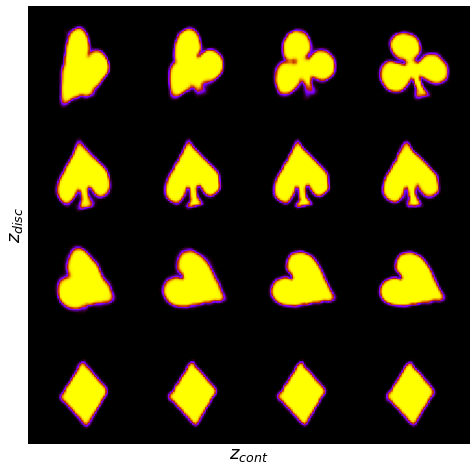

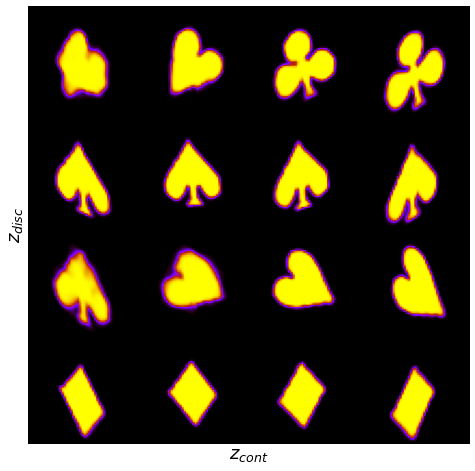

In [ ]:
# Decoded latent space:
# The latent space is uniformly sampled in z1-z2 latent dimensions. 
# These points are decoded back into the image space and are plotted in their corresponding latent space positions
# Since the latent space of crVAE is conditioned on the class label, we get one latent space for each class

# Traverse manifold is the decoded latent space in which one of the continouous latent dimension is held at constant (0),
# While the other continuous dimensions and the discrete dimension are used to plot the decoded latent space.
for i in range(2):
    ssrvae2.manifold_traversal(4, i, cmap='gnuplot')

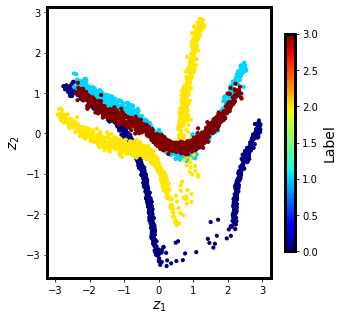

In [ ]:
targets_all2 = torch.argmax(labels_val2, dim = 1)   # Obtaining the classes from one-hot encoded vectors
z_mean2, z_sd2, pred_all2 = ssrvae2.encode(cards_val2.reshape([-1, 48*48]))   # Encoding the full validation dataset


# z_mean1: mean of the latent space representation of the input dataset, 
# z_sd1: standard deviation of the latent space representation of the input dataset,
# 0th column corresponds to angle and then the regular latent dimensions (First invariant dimensions and then regular latent dimensions) 
# Pred_all1: predicted class labels for the validation dataset 

# Latent distribution colored using the suit of each image
fig, ax = plt.subplots(1, 1, figsize =(5, 5))
im = ax.scatter(z_mean2[:,-1], z_mean2[:,-2], c=targets_all2, s=10, cmap='jet')
ax.set_xlabel("$z_1$", fontsize=14)
ax.set_ylabel("$z_2$", fontsize=14)
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label("Label", fontsize=14)
cbar.ax.tick_params(labelsize=10)
# plt.savefig('ssrvae_latent_dis_groundtruth.png', dpi = 300)
plt.show()

# It should be noted that these points live in four independent latent spaces corresponding to the predicted class
# And NOT the actual class like in crVAE

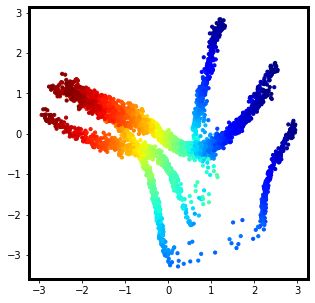

In [ ]:
# Latent distribution colored using the ground-truth shear of each image

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,5))

inds = np.zeros([len(targets_all2), 4], dtype = bool)
for i in range(4):
    inds[:, i] = np.asarray(targets_all2 == i, dtype = bool)

ax.scatter(z_mean2[inds[:,0], -1], z_mean2[inds[:,0],-2], c=shears_val2[inds[:,0],0], s=10, cmap='jet')
# ax[0,0].set_xlabel("$z_1$", fontsize=14)
# ax[0,0].set_ylabel("$z_2$", fontsize=14)

ax.scatter(z_mean2[inds[:,1], -1], z_mean2[inds[:,1],-2], c=shears_val2[inds[:,1],0], s=10, cmap='jet')
# ax[0,1].set_xlabel("$z_1$", fontsize=14)
# ax[0,1].set_ylabel("$z_2$", fontsize=14)

ax.scatter(z_mean2[inds[:,2], -1], z_mean2[inds[:,2],-2], c=shears_val2[inds[:,2],0], s=10, cmap='jet')
# ax[1,0].set_xlabel("$z_1$", fontsize=14)
# ax[1,0].set_ylabel("$z_2$", fontsize=14)

ax.scatter(z_mean2[inds[:,3], -1], z_mean2[inds[:,3],-2], c=shears_val2[inds[:,3],0], s=10, cmap='jet')
# ax[1,1].set_xlabel("$z_1$", fontsize=14)
# ax[1,1].set_ylabel("$z_2$", fontsize=14)

# plt.savefig('latent_dist_shear_all.png', dpi = 300)

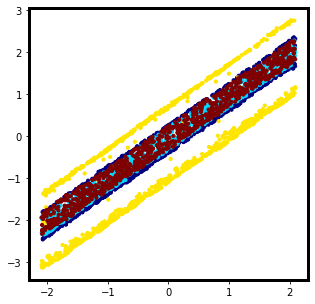

In [ ]:
# Finally the plot of encoded angle vs. ground truth rotation applied to the images. 
# The points are colored using the suit of the images.

fig, ax = plt.subplots(figsize = (5,5))
ax.scatter(torch.deg2rad(angles_val2), z_mean2[:,0], c = targets_all2, s =10, cmap = 'jet')

# plt.savefig('ssrvae_angles.png', dpi = 300)

In [ ]:
# As a final step of the analysis, we will visualize the confusion matrix between the predicted and the actual targets

from sklearn.metrics import accuracy_score, confusion_matrix
print('Accuracy on the validation dataset is {}'.format(accuracy_score(y_true = targets_all2, y_pred = pred_all2)))

con_mat = confusion_matrix(y_true = targets_all2, y_pred = pred_all2)

Accuracy on the validation dataset is 0.82875


So, we obtained a 98.4% accuracy on the validation dataset. Although the training and validation dataset come from a different distribution of the data (Higher rotations and high shear) than the supervised dataset (Low rotations and low shear), the VAE does an extremely good job of learning the patterns from supervised dataset and applying them to the unsupervised dataset.

Normalized confusion matrix
[[0.781 0.    0.219 0.   ]
 [0.    0.933 0.067 0.   ]
 [0.399 0.    0.601 0.   ]
 [0.    0.    0.    1.   ]]


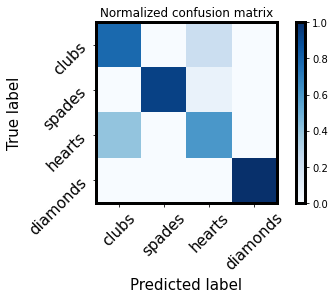

In [ ]:
# The confusion matrix looks like this:
class_names = ['clubs', 'spades', 'hearts', 'diamonds']

#show confusion matrix plot
plt.figure()
plot_confusion_matrix(con_mat, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
# plt.savefig('ssrvae_confusion_mat.png', dpi = 300)
plt.show()